# Assess predictablity over time

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import zscore
import os

In the previous two notebooks, we broke data out by term, and developed a routine for predicting MQ scores using only the justices' language in oral argument. We found that, at least in the case we examined, accuracy was highest / error was lowest with a rather small group of features: just 420 common words.

Now let's see if accuracy changes meaningfully over time. We could ultimately measure this in lots of different ways, but for ease of coding right now I'm just calculating the Pearson correlation between predicted and actual MQ scores.

In [11]:
midpoints = []
rs = []

for midpoint in range(1957, 2012):
    yearly = []

    for term in range(midpoint-2, midpoint+3):
        infile = '/Volumes/TARDIS/oralarg/termgrouped/term' + str(term) + '.tsv'
        if os.path.isfile(infile):
            data = pd.read_csv(infile, sep = '\t')
            yearly.append(data)

    data = pd.concat(yearly, ignore_index = True)

    data = data.loc[data.wordct > 100, : ]
    # I'm dropping rows with less than a hundred words,
    # because that's not much data.
    
    data.dropna(subset = ['mq'], inplace = True)

    data.reset_index(inplace = True)
    data = data.assign(z = zscore(data.mq))
    
    vectorizer = CountVectorizer(max_features = 420)
    termdoc = vectorizer.fit_transform(data.text)
    td = pd.DataFrame(termdoc.toarray())
    td = td.div(td.sum(axis=1), axis=0)

    predictions = [float('nan') for x in range(data.shape[0])]

    for judge in set(data.justice):

        # Now we're really going to identify rows associated
        # with a specific justice.

        justice_row_nums = data.index[data.justice == judge]
        justice_rows = td.loc[justice_row_nums, : ]

        other_row_nums = np.ones(td.shape[0], dtype = bool)
        # creates a list that's all True
        other_row_nums[justice_row_nums] = False
        # now we've masked the rows for this justice
        other_rows = td.loc[other_row_nums, : ]

        ridge = Ridge(alpha = 0.1, normalize = False)
        scaler = StandardScaler(with_mean = False)

        X = scaler.fit_transform(other_rows)
        y = zscore(data.loc[other_row_nums, 'mq'])

        ridge.fit(X, y)

        newX = scaler.transform(justice_rows)
        yhat = ridge.predict(newX)

        for rownum, prediction in zip(justice_row_nums, yhat):
            if not pd.isnull(predictions[rownum]):
                print('error')
            predictions[rownum] = prediction

    predictions = np.array(predictions)
    cor = pearsonr(predictions, data.z)[0]

    r2 = cor ** 2
    print(midpoint, cor, r2)
    rs.append(cor)
    midpoints.append(midpoint)
    

1957 0.0492469050465 0.00242525765666
1958 0.145943943332 0.0212996345952
1959 0.0443036089283 0.00196280976407
1960 -0.0471141729271 0.0022197452906
1961 -0.139095193749 0.0193474729242
1962 0.0121420014704 0.000147428199706
1963 0.052027600141 0.00270687117643
1964 0.0812480428271 0.00660124446323
1965 0.0767939375819 0.00589730884934
1966 0.0610362753325 0.00372542690647
1967 -0.104835658505 0.0109905152941
1968 0.0172722656165 0.000298331159527
1969 0.0955615751974 0.00913201465422
1970 0.116725223684 0.013624777844
1971 0.0652902981461 0.004262823032
1972 0.0783678544876 0.00614152061699
1973 -0.017494793111 0.000306067785998
1974 -0.0230198703809 0.000529914432353
1975 -0.0351775970708 0.00123746333567
1976 0.0781183532584 0.00610247711581
1977 0.0781155558144 0.00610204006019
1978 0.0652399757122 0.00425625443093
1979 0.16196737707 0.0262334312351
1980 0.203815083448 0.0415405882409
1981 0.22193853828 0.0492567147738
1982 0.137666346775 0.0189520230343
1983 0.113520688456 0.0128

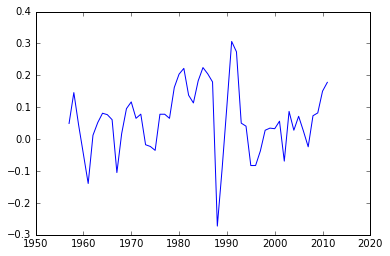

In [12]:
plt.plot(midpoints, rs)

### conclusion

I hate to say it, but that's not a meaningful trend. The variation from one year to the next is going to greatly exceed any secular trend. Moreover, accuracy is never very high; looking at the whole timeline, it's not even completely clear that it's meaningfully different from zero!

I suspect this is a blind alley.